# Install Transformers Library

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.8 MB 10.5 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
     |████████████████████████████████| 895 kB 30.8 MB/s 
     |████████████████████████████████| 3.3 MB 27.8 MB/s 
     |████████████████████████████████| 636 kB 36.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import transformers
from transformers import AutoModel, BertTokenizerFast
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/hate_speech/WELFake_Dataset.csv")
df = df.iloc[:,[2,-1]]
df.columns = ["text", "label"]
df.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [ ]:
df = df.sample(frac=0.07)
df.describe()
df.isnull().sum()

text     3
label    0
dtype: int64

In [ ]:
df['text']

29294    As commander-in-chief, shouldn t the Army fiel...
68371    Authorities Friday released the names of those...
61615    So the NYSE, Wall Street Journal and United Ai...
18277    By Gordon Duff, Senior Editor on November 1, 2...
8512     Climate march s are happening all over America...
                               ...                        
4641     EAST CHICAGO, Ind. (Reuters) - The head of the...
66618    House Speaker Paul Ryan is hugely unpopular, g...
69997    21st Century Wire says As  anti-Trump  protest...
9182     Donald Trump is pledging to bring up Bill Clin...
46004    Главная » News » Iran: 12 top officials arrest...
Name: text, Length: 5049, dtype: object

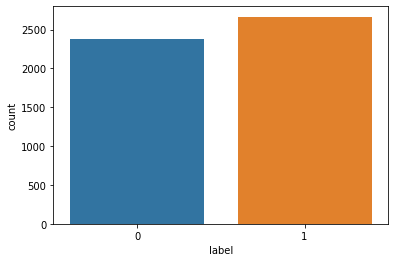

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="label", data=df);
plt.show()

In [ ]:
df.shape

(5049, 2)

In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

1    0.527827
0    0.472173
Name: label, dtype: float64

In [ ]:
df['text']=df['text'].apply(str)

In [ ]:
def clean_text(text):
    #Remove emojis and special chars
    clean=text
    #reg = re.compile('\\.+?(?=\B|$)')
    #clean = text.apply(lambda r: re.sub(reg, string=r, repl=''))
    #reg = re.compile('\x89Û_')
    #clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    reg = re.compile('\&amp')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='&'))
    reg = re.compile('\\n')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))

    #Remove hashtag symbol (#)
    #clean = clean.apply(lambda r: r.replace('#', ''))

    #Remove user names
    reg = re.compile('@[a-zA-Z0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='@'))

    #Remove URLs
    reg = re.compile('https?\S+(?=\s|$)')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='www'))

    #Lowercase
    #clean = clean.apply(lambda r: r.lower())
    return clean

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [ ]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

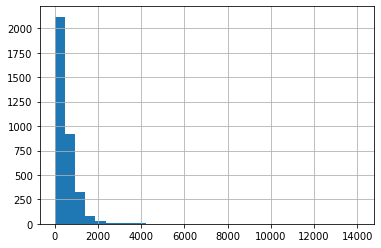

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      #_, cls_hs = self.bert(sent_id, attention_mask=mask)
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.0587178  0.94745308]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      #elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    111.
  Batch   100  of    111.

Evaluating...

Training Loss: 0.586
Validation Loss: 0.435

 Epoch 2 / 10
  Batch    50  of    111.
  Batch   100  of    111.

Evaluating...

Training Loss: 0.434
Validation Loss: 0.383

 Epoch 3 / 10
  Batch    50  of    111.
  Batch   100  of    111.

Evaluating...

Training Loss: 0.427
Validation Loss: 0.370

 Epoch 4 / 10
  Batch    50  of    111.
  Batch   100  of    111.

Evaluating...

Training Loss: 0.383
Validation Loss: 0.371

 Epoch 5 / 10
  Batch    50  of    111.
  Batch   100  of    111.

Evaluating...

Training Loss: 0.401
Validation Loss: 0.429

 Epoch 6 / 10
  Batch    50  of    111.
  Batch   100  of    111.

Evaluating...

Training Loss: 0.380
Validation Loss: 0.353

 Epoch 7 / 10
  Batch    50  of    111.
  Batch   100  of    111.

Evaluating...

Training Loss: 0.368
Validation Loss: 0.560

 Epoch 8 / 10
  Batch    50  of    111.
  Batch   100  of    111.

Evaluating...

Training Loss: 0.386
Validat

# Load Saved Model

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
preds

array([[-1.6408788 , -0.21543542],
       [-1.3067644 , -0.3156626 ],
       [-1.2937329 , -0.32054305],
       ...,
       [-0.01021196, -4.589293  ],
       [-0.64504313, -0.7436826 ],
       [-2.7670422 , -0.06490943]], dtype=float32)

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.92      0.78      0.84       358
           1       0.83      0.94      0.88       400

    accuracy                           0.86       758
   macro avg       0.87      0.86      0.86       758
weighted avg       0.87      0.86      0.86       758



In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,279,79
1,25,375


In [ ]:
cf_matrix = confusion_matrix(test_y, preds)

In [ ]:
cf_matrix 

array([[279,  79],
       [ 25, 375]])

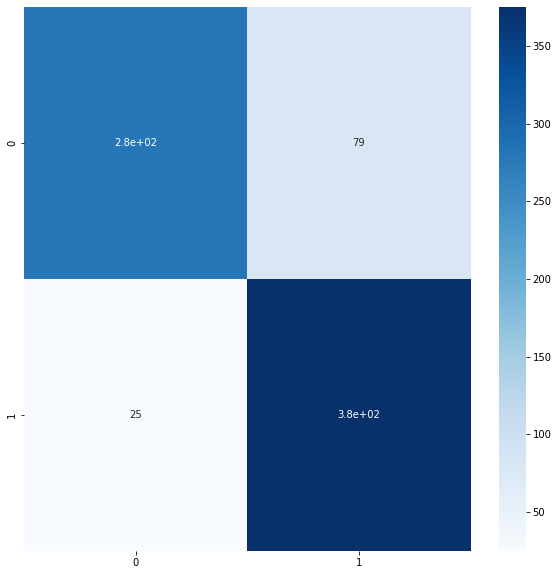

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax = ax)

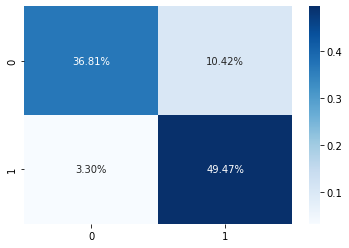

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

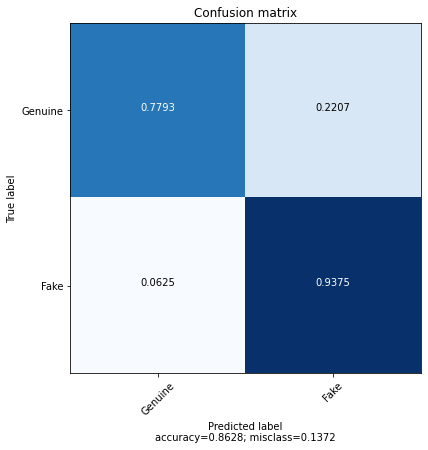

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

cm = confusion_matrix(test_y, preds)
labels = ["Genuine",  "Fake"]

plot_confusion_matrix(cm,labels,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)
 